# Transcription Factor Binding Predictor Task

The model in this notebook is inspired by the following work:
- "A Primer on Deep Learning in Genomics" (*Nature Genetics, 2018*) by James Zou, Mikael Huss, Abubakar Abid, Pejman Mohammadi, Ali Torkamani & Amalio Telentil. [Link](https://www.nature.com/articles/s41588-018-0295-5).
- Neural Network for Sequence Data github: [Link](https://github.com/const-ae/Neural_Network_DNA_Demo)
- CKN model: [Link](https://gitlab.inria.fr/dchen/CKN-seq)

## 1. Introduction

The model in this notebook is built to predict the binding probability of a certain Transcription Factor (TF) to DNA sequences.
The data provided in **`train.csv`** contains only the positive DNA sequences that bind to the TF.

I use three different techniques to generate the negative non-binding samples. The details of the negative samples generation and the architecture are discussed in the following sections, which was an important factor in improving the performance of the model.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random

seed = 1234
random.seed(seed)

# from google.colab import drive
# drive.mount('/gdrive')
# %cd '/gdrive/My Drive/Research/TFP_task'

## 2. Data Preparation

The positive DNA sequences are loaded from **`train.csv`**. There are 7500 positive DNA sequences of maximum length of 64 nucleobases.

For the negative samples, I use three methods:
- Even-odd shuffling
- Random flipping for DNA bases with certain ratios
- Random synthesis of DNA through extracted unique n-grams

I found out that, by experimenting with different techniques used, that the choice of the negative samples generation methods **significantly** affects the
performance of the classifier.

When the negative samples are less structured and more random, the classifier reaches almost 100% accuracy. On the other hand, when the negative samples
resemble the original DNA sequence, it becomes harder for the classifier to perform well.

**Therefore**, to increase the capacity of the classifier to perform well on held-out data, I mixed the three techniques describe above.

**`Future Work`**: There are more methods that can be considered for the negative class data creation that might help better generalization, including:
- Training a model to generate DNA-like sequences in an unsupervised way, and use it to create negative samples.
- Use DNA sequences from other sources that are independent of the transcription factor TF to use as negative samples.

In [3]:
from helper.SequenceHelper import do_dinucleotide_shuffling, augment_noise, augment_grams, merge_shuffle_neg_samples, parse_pad_onehot_encode

# Load positive samples from the file
#============

seq_file = 'train.csv'
pos_seq_df = pd.read_csv(seq_file, header=None)[0]

#============
# Negative samples generation:

# Do positions shuffling based on even and odd positions
_neg_odd_even = do_dinucleotide_shuffling(pos_seq_df)

# Extract all unique n-grams and generate new DNA samples out of them
_neg_grams, _grams_extract = augment_grams(pos_seq_df, n_gram=5)
print("Extracted n_ngrams {} =".format(len(_grams_extract)), _grams_extract[:len(_grams_extract)-10], "...")

# Do random flipping of nucleobases, and merge all different negative samples together
neg_target_length = pos_seq_df.values.shape[0]
neg_seq_df = merge_shuffle_neg_samples([augment_noise(pos_seq_df, noise=0.2), augment_noise(pos_seq_df, noise=0.3), _neg_grams, _neg_odd_even],
                                       neg_target_length)

# Do padding and one-hot enconding of inputs
train_one_hot_encoded = parse_pad_onehot_encode(pd.concat([pos_seq_df, neg_seq_df], ignore_index=True))

seq_length = train_one_hot_encoded.shape[1]
n_alphabet = 5
print("Max seq length = ", seq_length)
print("Some negative samples (Max Len. {})".format(np.max([len(e) for e in neg_seq_df.values])))
neg_seq_df.head()

Extracted n_ngrams 1024 = ['CTCCG' 'GAGAT' 'TGGTA' ... 'AGTGC' 'GTATC' 'CGCCA'] ...
Max seq length =  64
Some negative samples (Max Len. 64)


0       AGCTGAGTCAGTAACCACAGGCTGCAACTCTATCTGACATAACTCA
1    CAGATGCTGGTACAAATCGCCGAGGTTGTTCTCTTCGCCACCTATACTG
2        AACAGTTGCCTATCCATGGCCCAACGTCTTGGGACGAGTTCGACC
3    GGCTTTAGAGAACCGCTCAGCAATAGCATGCTGAGACCTTCCCCCC...
4    GTGAGTGTTAAAGCCGCAGTAGCTTGTAAGTCCATAGGTAGTTCGA...
Name: 0, dtype: object

In [4]:
from sklearn.preprocessing import OneHotEncoder

#Create the classification labels
_Y = np.concatenate((np.ones(pos_seq_df.values.shape[0]), np.zeros(neg_seq_df.values.shape[0])))
# one_hot_encoder = OneHotEncoder(categories='auto')
# labels = np.array(_Y).reshape(-1, 1)
# _Y = one_hot_encoder.fit_transform(labels).toarray()
# print('Labels:\n',labels.T)
# print('One-hot encoded labels:\n',_Y)

# Random shuffle the data
shuffling_index = np.arange(train_one_hot_encoded.shape[0])
np.random.shuffle(shuffling_index)
input_features = train_one_hot_encoded[shuffling_index, :, :]
input_labels = _Y[shuffling_index]

## 3. Build the Model Architecture

There are two different deep architectures that can be used for the classifier, convolutional neural networks **(CNN)**, and recurrent neural networks **(RNN/LSTM)**.
 - CNNs are commonly used in deep learning genomics applications. Recurrent networks like bidirectional LSTMs gave slightly better results with
 similar or fewer
 number of
parameters. However, they were slower to train.

The details of the architecture of the neural network are shown by running `model.summary()`.

### 3.1 Build a logistic Regression classifier for baseline comparison
But first, we try a simple baseline like the logistic regression, in order to compare with the selected architecture:

In [5]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, BatchNormalization, Dropout, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1L2
import tensorflow as tf
tf.random.set_seed(seed)

def build_log_regr(recurrent=False):
    model = Sequential()
    model.add(Dense(1, activation='sigmoid', input_shape=(input_features.shape[1] * n_alphabet, ), kernel_regularizer=L1L2(l1=0.01, l2=0.01)))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy']) #
    model.build()
    return model

from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc, average_precision_score
# Define the K-fold Cross Validator
kfold = KFold(n_splits=3, shuffle=True, random_state=seed)
# K-fold Cross Validation model evaluation
fold_no, best_fold = 1, {}

_log_regr_input_features = np.reshape(input_features, (input_features.shape[0], -1))
for _train, _test in kfold.split(_log_regr_input_features, input_labels):
    print("Logistic Regression Fold #{} -------- ".format(fold_no))
    _log_reg = build_log_regr()
    history = _log_reg.fit(_log_regr_input_features[_train], input_labels[_train], batch_size=32,
                         epochs=50, verbose=0, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)])

    predicted_labels = _log_reg.predict(_log_regr_input_features[_test]).flatten()  #[:, 1] for softmax  # .flatten() for sigmoid
    roc_labels = input_labels[_test, 1] if len(input_labels.shape) >= 2 else input_labels[_test]
    fpr, tpr, thresholds = roc_curve(roc_labels, predicted_labels)
    _auc = auc(fpr, tpr)
    print("Logistic Regression AUC {:.4f}".format(_auc))
    # print("Logistic Regression AUPRC {:.4f}".format(average_precision_score(roc_labels, predicted_labels)))

    test_loss, test_acc = _log_reg.evaluate(x=_log_regr_input_features[_test], y=input_labels[_test], verbose=0)
    print("Logistic Regression Test accuracy: {:.4f}".format(test_acc))
    fold_no += 1

Logistic Regression Fold #1 -------- 
Epoch 00015: early stopping
Logistic Regression AUC 0.7248
Logistic Regression Test accuracy: 0.6682
Logistic Regression Fold #2 -------- 
Epoch 00024: early stopping
Logistic Regression AUC 0.7451
Logistic Regression Test accuracy: 0.6822
Logistic Regression Fold #3 -------- 
Epoch 00012: early stopping
Logistic Regression AUC 0.7400
Logistic Regression Test accuracy: 0.6740


- We can see that the logistic classifier can not reach higher than 0.70 test accuracy.

### 3.2 Build a deep network classifier
- We start from a common 1-dimensional CNN model used widley in the literature, followed by dense layers for classification.
- During experiments, I found that the performance has improved by using regularization like dropout after each layer.

In [6]:
def build_model(recurrent=False):
    model = Sequential()

    if recurrent:
        model.add(Bidirectional(LSTM(10), input_shape=(input_features.shape[1], n_alphabet)))
        model.add(Dropout(0.2))
    else:
        model.add(Conv1D(filters=32, kernel_size=12, input_shape=(input_features.shape[1], n_alphabet), activation='relu'))  #, activation='relu'
        model.add(Dropout(0.2))
        model.add(MaxPooling1D(pool_size=4))
        model.add(Flatten())

    # Either softmax or sigmoid can be used in the final layer, however,
    # using the sigmoid allowed for softer probabilities, that enhanced 
    # the interpretation visualization for motif sites after training.
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    model.build()
    return model

_model = build_model()
_model.summary()
del _model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 53, 32)            1952      
_________________________________________________________________
dropout (Dropout)            (None, 53, 32)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 13, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 416)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                13344     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

## 4. Training/Evaluation and model selection

### 4.1 The training/evaluation/selection loop
The training and evaluation of the model is contained in the training loop  below.
- I use K-fold model selection to select the best train/test data split.
For every fold, the area under the curve *(AUC)* and the test accuracy are printed.

In [7]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc, average_precision_score

# Define the K-fold Cross Validator
kfold = KFold(n_splits=3, shuffle=True, random_state=seed)

# K-fold Cross Validation model evaluation
fold_no, best_fold, best_auc = 1, {}, 0.0

# The main training and evaluation loop
for _train, _test in kfold.split(input_features, input_labels):

    print("Fold #{} ------ ".format(fold_no))
    _model = build_model()
    history = _model.fit(input_features[_train], input_labels[_train], batch_size=32,
                         epochs=50, verbose=0, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)])

    predicted_labels = _model.predict(input_features[_test]).flatten()  #[:, 1] for softmax  # .flatten() for sigmoid
    roc_labels = input_labels[_test, 1] if len(input_labels.shape) >= 2 else input_labels[_test]
    fpr, tpr, thresholds = roc_curve(roc_labels, predicted_labels)
    _auc = auc(fpr, tpr)
    print("AUC {:.4f}".format(_auc))
    # print("AUPRC {:.4f}".format(average_precision_score(roc_labels, predicted_labels)))

    test_loss, test_acc = _model.evaluate(x=input_features[_test], y=input_labels[_test])
    print("Test accuracy: {:.4f}".format(test_acc))
    if _auc > best_auc:
        best_fold = {"model": _model, "train": _train, "test": _test, "auc": np.round(_auc, 3), "test_loss": np.round(test_loss, 3)
            , "test_acc": np.round(test_acc, 3), "history": history}
        best_auc = _auc
    fold_no += 1

test_features = input_features[best_fold["test"]]
test_labels = input_labels[best_fold["test"]]
model = best_fold["model"]
print("Best model:", {"auc": best_fold["auc"], "test_loss": best_fold["test_loss"], "test_acc": best_fold["test_acc"]})

Fold #1 ------ 
Epoch 00013: early stopping
AUC 0.9539
157/157 [==============================] - 0s 1ms/step - loss: 0.2388 - accuracy: 0.9140
Test accuracy: 0.9140
Fold #2 ------ 
Epoch 00015: early stopping
AUC 0.9426
157/157 [==============================] - 0s 1ms/step - loss: 0.2788 - accuracy: 0.8948
Test accuracy: 0.8948
Fold #3 ------ 
Epoch 00017: early stopping
AUC 0.9455
157/157 [==============================] - 0s 1ms/step - loss: 0.2663 - accuracy: 0.9040
Test accuracy: 0.9040
Best model: {'auc': 0.954, 'test_loss': 0.239, 'test_acc': 0.914}


- We can see that the deep network performs much better than the baseline. The training loop stops when the validation loss stops decreasing in order to make
sure that the network does not overfit.
- We can also see that the test accuracy is high (> (90%)), which indicates that the network did not overfit, and it can perform well on held-out data.

### 4.2 Performance analysis


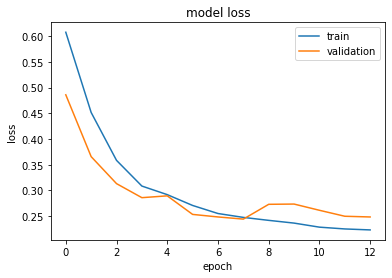

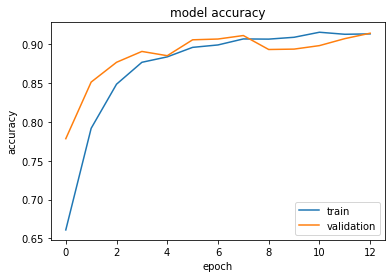

In [8]:
#Plot training loss and accuracy curves

plt.figure()
plt.plot(best_fold["history"].history['loss'])
plt.plot(best_fold["history"].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

plt.figure()
if len(input_labels.shape) >= 2:
    plt.plot(best_fold["history"].history['binary_accuracy'])
    plt.plot(best_fold["history"].history['val_binary_accuracy'])
else:
    plt.plot(best_fold["history"].history['accuracy'])
    plt.plot(best_fold["history"].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

- The training and validation curves shown above show steady decrease in the loss for most of the training epoch, and the training stops early before the
validation loss start to increase, where overfitting starts to happen.
- The validation loss decrease is an important sign for the performance of the model to generalize well beyond the data seen during training.

## 5. Interpret
*[Please rerun this code cell below to browse more DNA interpretations]*

### 5.1 Computing importance scores
To understand why the neural network classifies a DNA sequence as binding or not, We can compute a **_importance scores_** for each nucleobase **(A, C, G,
T)**
 in the input
 DNA.
- This importance score can show how this particular nucleobase affects or contributes to the positive or negative classification of the whole sequence.
- A simple way to calculate this importance score is the following:
    - Feed the classifier the DNA sequence with every nucelobase removed at a time.
    - compare the new prediction probability with the nucleobase removed with the prediction probability of the full sequence containing the nucleobase.
    - The difference in probabilities is an indication of the importance of this nucleotide on the positive or negative prediction.

- There are also other advanced methods to compute importance scores:
    - Generating saliency maps using the gradient of the model's prediction with respect
 to each individual nucleobase.
    - Employ an interpretable model like ["Learning to explain (L2X)"](https://github.com/Jianbo-Lab/L2X), where importance scores can be learned during the
    training, and later be used to identify important motifs and TF binding preferences.

By plotting the DNA sequence with each nucleobase magnified in proportion to its importance, this can provide some clues about what sequence of nucleobases
form
the binding motive for the transcription factor (TF) that we are trying to identify.

Sequences Predictions [0.951 0.002 0.001 0.964 0.89 ]
Prediction probability =0.9509999752044678


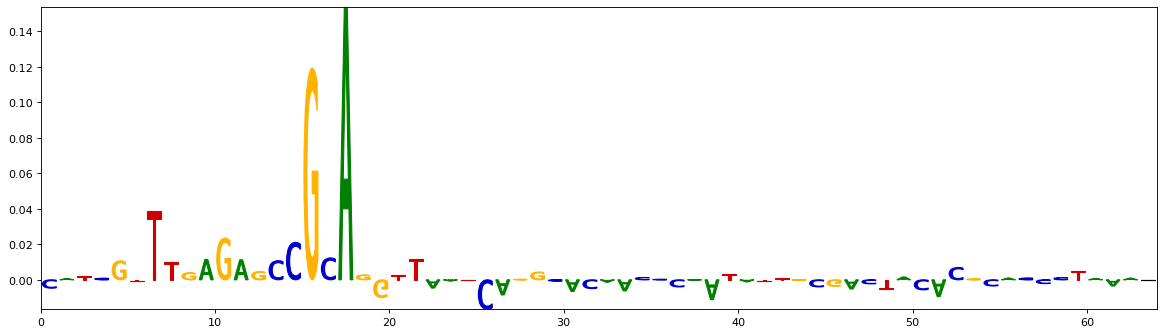

Prediction probability =0.0020000000949949026


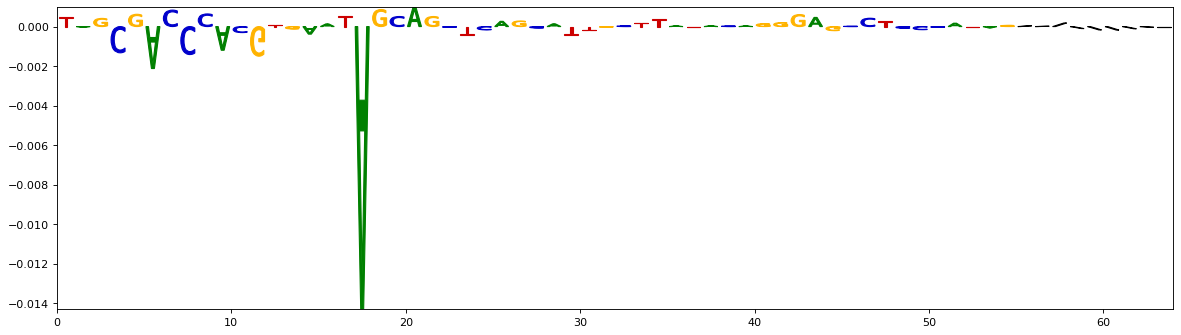

Prediction probability =0.0010000000474974513


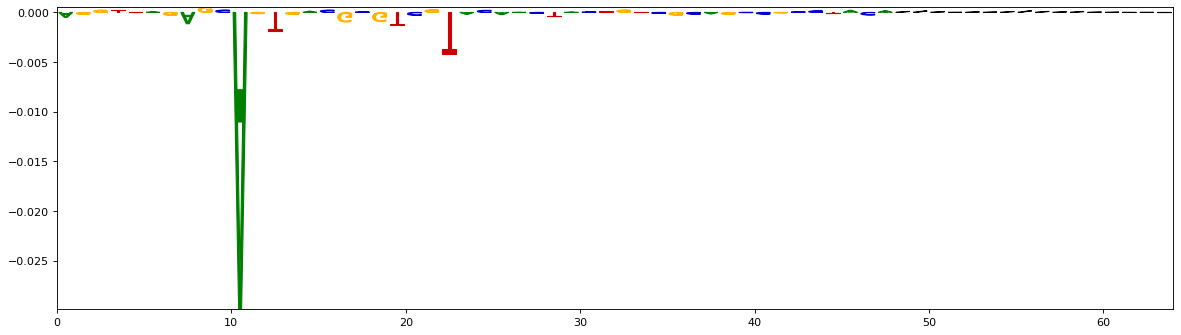

Prediction probability =0.9639999866485596


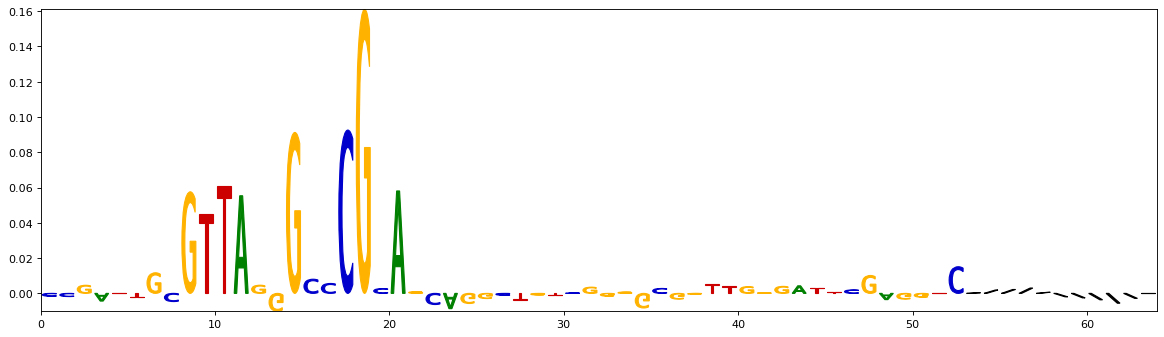

Prediction probability =0.8899999856948853


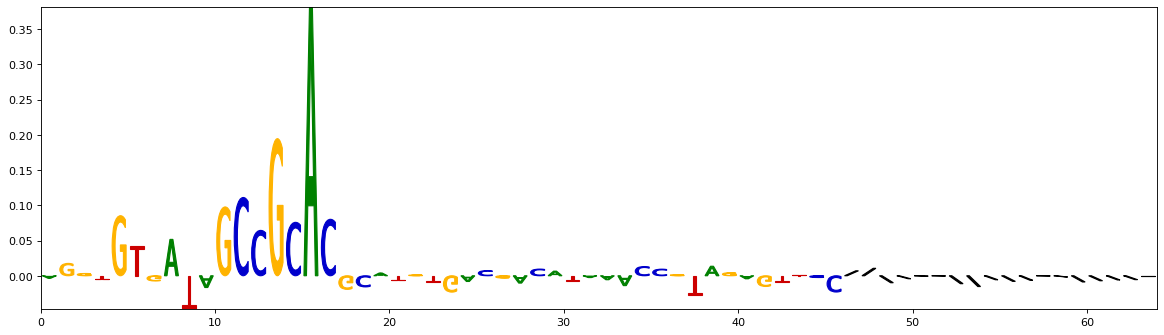

In [16]:
# Plot the motif importance for few random sequences
plot_index = np.random.randint(0, len(test_features), 5)

# Get the classification probabilities for the original sequences we want to plot
seq_matrix_for_plotting = test_features[plot_index, :]
plotting_pred = model.predict(seq_matrix_for_plotting).flatten()  #[:, 1] for softmax  # .flatten() for sigmoid
print("Sequences Predictions", np.round(plotting_pred, 3))

# Generate a new set of sequences where for each sequence every nucleobase is consecutively set to 0
tmp = np.repeat(seq_matrix_for_plotting, seq_length, axis=0)

a = np.ones((seq_length, seq_length), int)
np.fill_diagonal(a, 0)
b = np.repeat(a.reshape((1, seq_length, seq_length)), seq_matrix_for_plotting.shape[0], axis=0)
c = np.concatenate(b, axis=0)
seq_deleted = np.multiply(tmp, np.repeat(c.reshape((tmp.shape[0], seq_length, 1)), n_alphabet, axis=2))

# Calculate the prediction for each sequence with one deleted nucleotide
seq_deleted_pred = model.predict(seq_deleted, batch_size=32).flatten()  #[:, 1] for softmax  # .flatten() for sigmoid

# Score (option 1): Difference between prediction and seq_deleted_pred
scores = np.reshape((np.repeat(plotting_pred, seq_length) - seq_deleted_pred), (len(plot_index), seq_length))

# Score (option 2): Ratio between (1-d_pred) and (1-prediction)
# scores = np.reshape((1-d_pred)/(1-np.repeat(plotting_pred, seq_length))-1, (len(plot_index), seq_length))

# Clip numbers to reasonable range
scores = np.clip(scores, -1.0, 1.0)

%matplotlib inline
import motif_plotter

for idx in range(0, len(plot_index)):
    print("Prediction probability ={}".format(np.round(plotting_pred[idx], 3)))
    fig = plt.figure(figsize=(18, 5), dpi=80)
    ax = fig.add_subplot(111)
    motif_plotter.make_single_sequence_spectrum(ax,
                                                seq_matrix_for_plotting[idx].reshape((seq_length, n_alphabet)),
                                                np.arcsinh(scores[idx]).reshape(seq_length, 1), 
                                                one_hot_decoding=["/", 'A', 'C', 'T', 'G'],
                                                colors=['#000000', '#008000', '#0000cc', '#cc0000', '#ffb300'])
    plt.show()

### 5.2 Binding preferences
The results above show high importance scores for the motif **_CCGCA_** appearing in the positively classified DNA sequence.
There are some additional motifs that also appear to have some effect on the TF binding, like **_GTTT_**, **_GTTG_** and **_GTTA_**, and they usually precede
 the
 main **_CCGCA_** motif by few nucleobases.
